# Twitter Tribes 2: Who should you follow?

This model aims to predict connections in a network and recommend what connections should you also follow given what your friends follow. For the entire analysis visit [this link](https://medium.com/@alvaroaguado3/can-you-infer-who-to-follow-on-twitter-ebb9d3baa6a6)

First let's load the libraries that we will use for this analysis

In [655]:
# Magic line to ensure plotting happens in Jupyter
%matplotlib inline

# Import libraries for the code
import time
import json
import tweepy
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn 
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelBinarizer #Data pre-processing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report #Optimization and Measure of Classification accuracy
from sklearn.tree import DecisionTreeClassifier 
from scipy import spatial,sparse
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [2]:
# Set up plot size for the plots that we will be showing
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Now we need to load the data that we will be analyzing. This time we created datasets the same way we did in the previous post, but we expanded to friends of friends in the network. 
We first remove those accounts that don't have at least 3 edges with users. Let's see how the data looks like

In [10]:
def convert_dfs(raw_network):
    '''
    Function takes the original network of connections and the connection of sample of friends and 
    returns a networkx ready table
    '''    
    raw_network_crosstab = pd.crosstab(raw_network.orig,raw_network.target)
    idx = raw_network_crosstab.columns.union(raw_network_crosstab.index)
    network = raw_network_crosstab.reindex(index = idx, columns = idx, fill_value = 0)
    return network    

In [1179]:
# Load Files
shell = pd.DataFrame(data = None, columns = ["orig","target","friends","followers"])
lst = ["base_df.pkl","sdf.pkl","gandyno_sdf.pkl","gandyno_df.pkl","sara_df.pkl","sara_sdf.pkl","osuna_sdf.pkl"]
#lst = "base_df.pkl","gandyno_df.pkl"

for i in lst:
    file = open(i, 'rb')
    new = pickle.load(file)
    shell = pd.concat([shell,new])

combined_df = shell.drop_duplicates()

#Create the graph friendly table for me and my friends connections
raw_network  = combined_df.loc[:,["orig","target"]]
dfg = convert_dfs(raw_network)

# Clean up values and create adjacency table for graph with users only
dfg2 = dfg[dfg.index.isin(users)]
dfg2 = dfg2.apply(lambda x: np.where(x > 0,1,0))
dfg2

users = combined_df.orig.drop_duplicates()
dfgN = dfg2[dfg2.columns[dfg2.sum(axis=0) > 3]]
dfgN

,BarackObama,ComandanteLara,DANIROVIRA,Frank_Cuesta,IbaiLlanos,InesArrimadas,JotDownSpain,JustinTrudeau,MiguelMorenatti,RafaelNadal,...,gandyno,guardiacivil,inglesaldia,muyinteresante,neuronalnet,norcoreano,osuna_vasco,perezreverte,policia,sarayeinguer
LionARMYstaff,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
MiguelYuste8,0,1,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,1,1,0
RafaSei,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,0
Sai00079520,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
alvaro_sevi10,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
alvarofm84,0,1,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0
analyticsrl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gandyno,1,1,1,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,1,0,1
gontz87,1,0,1,0,0,0,1,0,0,0,...,1,0,1,1,0,1,0,1,0,1
kimytouw,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Let's also visualize the data that we have.

In [1180]:
# In order to create network with the agents that we will be analyzing
names = np.concatenate((users.values,dfgN.columns.values),axis = None)
names = np.unique(names)
dfg1 = dfg.iloc[dfg.index.isin(names),dfg.columns.isin(names)]
dfg1 = dfg1.apply(lambda x: np.where(x > 0,1,0))

# For Graph estimate accounts we will be predicting
dfg0 = dfg.iloc[dfg.index.isin(dfgN.columns.values)]
dfg0 = dfg0.apply(lambda x: np.where(x > 0,1,0))

columns = dfgN.columns.values
rows = users.values

C = np.searchsorted(columns, rows)
D = np.delete(np.arange(np.alen(columns)), C)

# For graph with accounts only
dfg3 = dfg.iloc[dfg.index.isin(columns[D])]
dfg3 = dfg3.apply(lambda x: np.where(x > 0,1,0))
dfg3

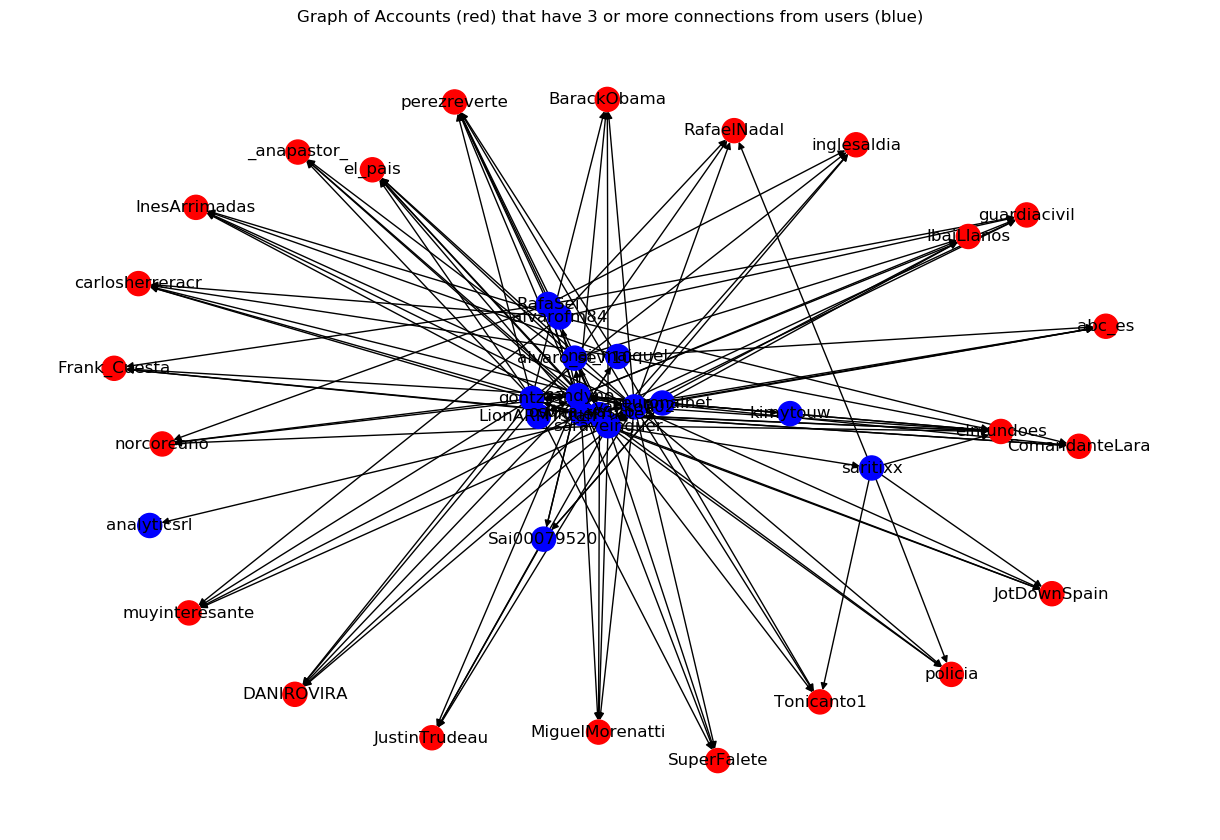

In [455]:
# Create a raw graph with all the agents in the analysis
np.random.seed(42)
G = nx.from_pandas_adjacency(dfg1,create_using = nx.DiGraph)
color_map = []
for node in dfg1.index.values:
    if pd.Series(node).isin(rows)[0]:
        color_map.append('blue')
    else: 
        color_map.append('red')  

pos = nx.spring_layout(G)
nx.draw(G,pos = pos,with_labels=True,node_color=color_map)
#nx.draw(G,)
plt.title('Graph of Accounts (red) that have 3 or more connections from users (blue)')
plt.show()

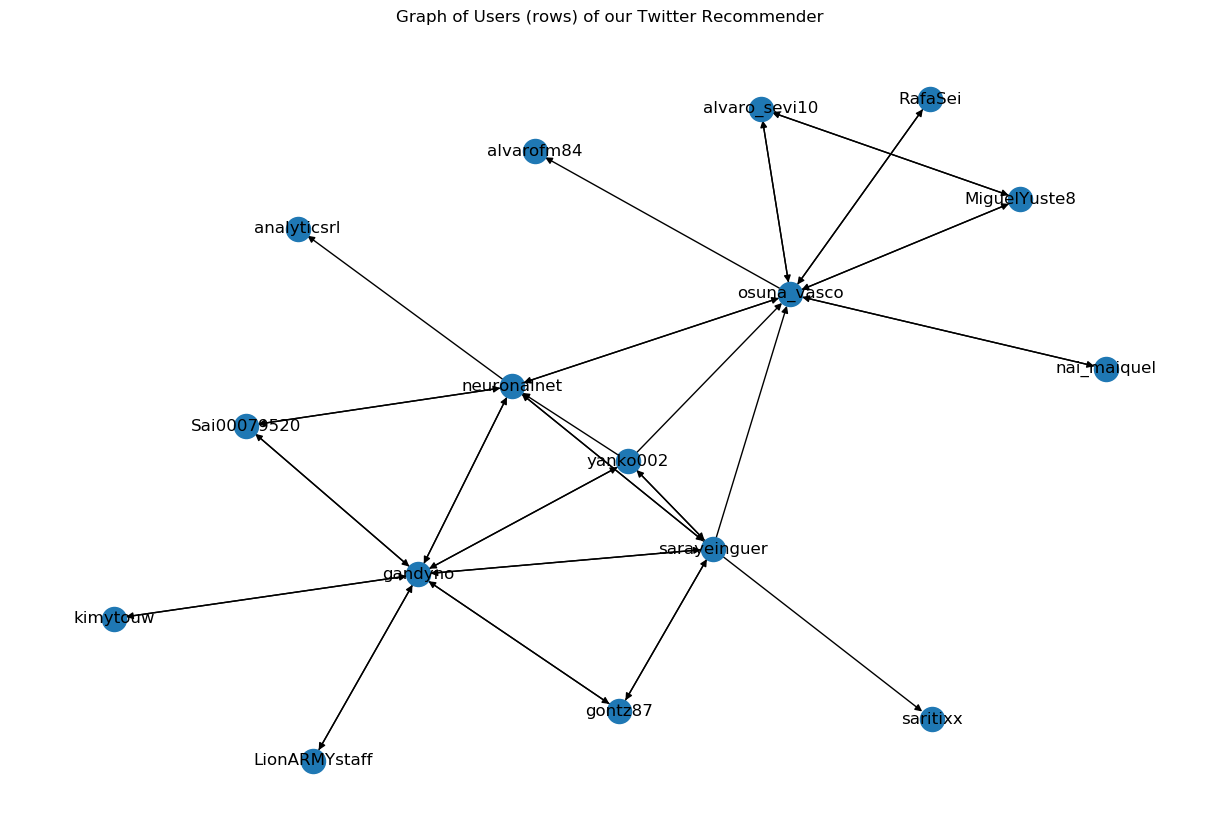

In [456]:
# Create a raw graph with only users
np.random.seed(42)
G = nx.from_pandas_adjacency(dfg2,create_using = nx.DiGraph)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos = pos,with_labels=True)
#nx.draw(G,)
plt.title('Graph of Users (rows) of our Twitter Recommender')
plt.show()

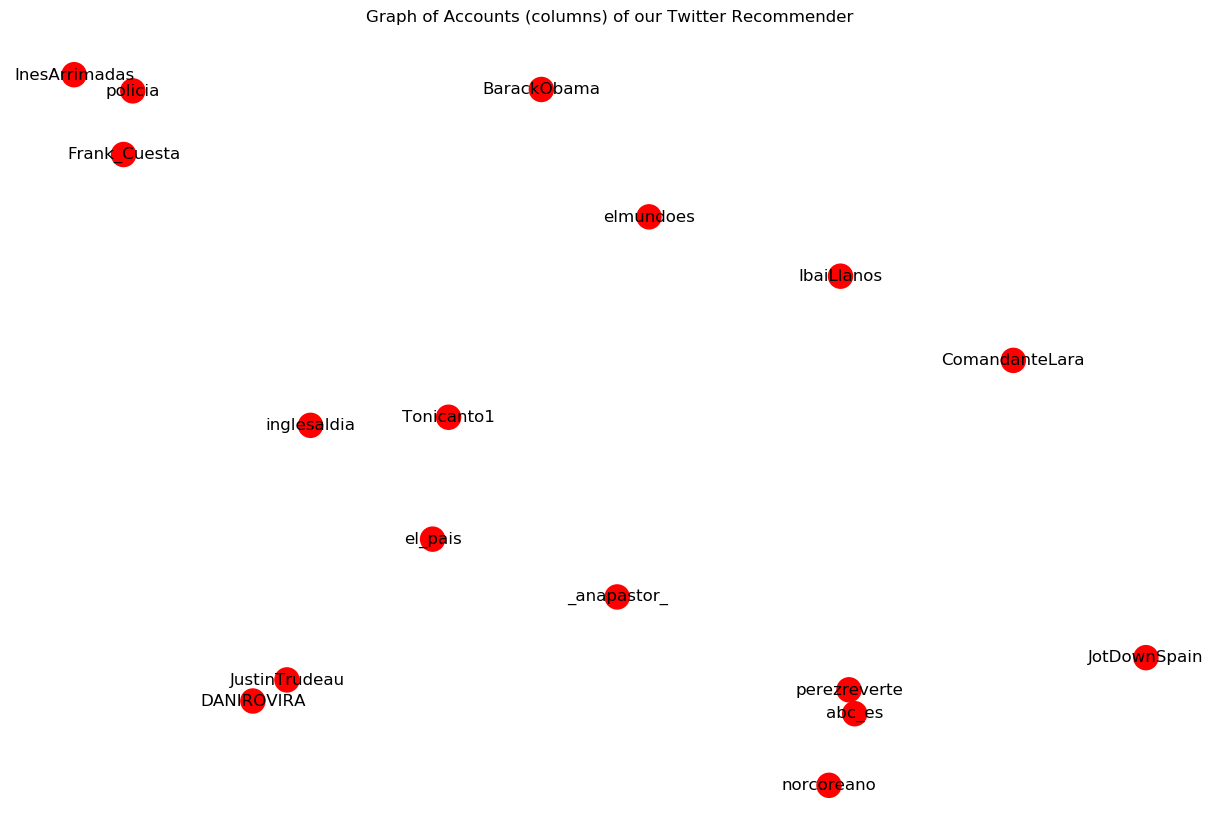

In [460]:
# Create a raw graph with the accounts we will be using for prediction
np.random.seed(42)
G = nx.from_pandas_adjacency(dfg3,create_using = nx.DiGraph)
pos = nx.random_layout(G)
nx.draw(G,pos = pos,with_labels=True,node_color=np.repeat('red',17))
#nx.draw(G,)
plt.title('Graph of Accounts (columns) of our Twitter Recommender')
plt.show()

We are also going to create labels for the account types based on the aamount of friends and follows of each account. The conditions are arbitrary but we can see that more or less they make sense.

In [1198]:
#Create the type column based on Friends and followers
combo = combined_df[combined_df.target.isin(columns)]
combo = combo.iloc[:,1:4].drop_duplicates()
combo['ratio'] = combo.followers/(combo.friends+1)
combo['type'] = np.where(((combo.friends > 1300) & (combo.followers > 100000) | (
    (combo.friends > 700) & (combo.followers > 100000) & (combo.ratio.between(6000,11000)))),'News',
        np.where((combo.friends < 1300) & (combo.followers > 10000),'Influencer',
                 'Regular'))
pd.set_option('display.max_rows', 102)
combo.drop_duplicates(subset=['target'], keep="first", inplace=True)
combojoin = combo.iloc[:,[0,4]]
combojoin = combojoin.rename(columns = {'target':'variable'})
combojoin

,variable,type
47,abc_es,News
52,osuna_vasco,Regular
58,gandyno,Regular
67,IbaiLlanos,Influencer
72,sarayeinguer,Regular
25,Frank_Cuesta,Influencer
30,neuronalnet,Regular
75,MiguelMorenatti,Influencer
77,carlosherreracr,Influencer
78,ComandanteLara,Influencer


Let's now implement the workflow that we will use in order to sample and predict connections

In [1157]:
### Workflow to sample and extract prediction

# Select user and random variable. Remove from Adjacency Matrix
def select_random(dfgN,n = 1,random_state = np.random.RandomState()):    
    sam_dfgN = dfgN.sample(n = n, random_state = random_state)
    rest_dfgN = dfgN.drop(sam_dfgN.index)
    return(sam_dfgN,rest_dfgN)


# Select Column to predict at random
def target_account(one,n = 1, random_state = np.random.RandomState()):
    label = one.sample(n = n,axis = 1,random_state = random_state).columns.values[0]
    ith = np.where(one.columns.values == label)[0][0]
    return(ith,label)



# Calculate Similarity Matrix (Cosine Similarity) and Select N closest variables

def calc_similarity(two,n = 4,ith = ith):
    A = np.matrix(two)
    A_sparse = sparse.csr_matrix(A)
    similarities_sparse = cosine_similarity(A_sparse.T,dense_output=False)
    similarities_sparse.sort_indices()
    arrayith = similarities_sparse[ith].toarray()
    idx = arrayith[0].argsort()[-n:]
    return(idx, arrayith[0][idx])



# Prepare dataframe X_train X_test , y_train, y_test
def train_test(one,two,idx):
    n = len(idx)
    test = one.iloc[:,idx]
    train = two.iloc[:,idx]
    X_train = train.iloc[:,:n-1]
    y_train = train.iloc[:,n-1]
    X_test = test.iloc[:,:n-1]
    y_test = test.iloc[:,n-1]
    return(X_train,X_test,y_train,y_test)

# Create entry for labelclasee

def label_dataset(one,two,combojoin,idx):
    test = one.iloc[:,idx]
    train = two.iloc[:,idx]
    df = pd.concat([test,train],axis = 0)
    vals = df.columns.values.tolist()
    dictionary = combojoin[combojoin.variable.isin(vals)]
    dictionary = dictionary.set_index('variable')
    toindex = dictionary.loc[vals].index.values[3]
    rows = dictionary.loc[vals].T.values
    newlist = rows.tolist()[0]
    listval = np.append(rows,toindex).tolist()
    out = pd.DataFrame(data = [listval], columns = ['clus1','clus2','clus3','target','toindex'])
    out.set_index('toindex')
    return(out)


# Calculate KNN Neighbours with Jaccard
def calc_knn(X_train,X_test,y_train,k = 3, metric = 'jaccard'):
    #clf = svm.SVC(probability =False)
    #clf.fit(X_train,y_train)
    #pred = clf.predict(X_test)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k,metric = 'jaccard')
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)[0]
    return(pred)

# Put it together
def workflow(dfgN, nrow = 1, ncol = 1, n_sim = 4, k = 3,metric = 'jaccard',random_state = np.random.RandomState(),combojoin = combojoin):
    one,two = select_random(dfgN,n = nrow, random_state = random_state)
    ith, label = target_account(one,n = ncol, random_state = random_state)
    idx, sim_sparse = calc_similarity(two,n = n_sim, ith = ith)
    X_train, X_test, y_train, y_test = train_test(one,two,idx)
    y_pred = calc_knn(X_train,X_test,y_train, k = k, metric = metric)
    class_i = label_dataset(one,two,combojoin,idx)
    return(y_pred,y_test,ith,one,X_test,class_i)

y_pred, y_test, ith, one, X_test,class_i = workflow(dfgN, nrow = 1, ncol = 1, n_sim = 4, k = 3, metric = 'jaccard', random_state = 12345,combojoin = combojoin)

Let's run this for 1000 cases and see how does our model perform

In [1163]:
y_pred_list = []
y_test_list = []
class_train = []

for i in range(0,1000):
    y_pred, y_test, ith, one, X_test, class_i = workflow(dfgN, nrow = 1, ncol = 1, n_sim = 4, k = 3, metric = 'jaccard', random_state = i,combojoin = combojoin)
    y_pred_list.append(y_pred)
    y_test_list.append(y_test)    
    class_train.append(class_i.iloc[0,:])

In [1199]:
# Get Classification results
print(confusion_matrix(y_test_list, y_pred_list))
print(accuracy_score(y_test_list, y_pred_list))

print(pd.DataFrame(confusion_matrix(y_test_list, y_pred_list),
                       columns=['Pred neg', 'Pred pos'], 
                       index=['Actual neg', 'Actual pos']))

print(classification_report(y_test_list, y_pred_list))

            Pred neg  Pred pos
Actual neg       456       227
Actual pos       126       191
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       683
           1       0.46      0.60      0.52       317

    accuracy                           0.65      1000
   macro avg       0.62      0.64      0.62      1000
weighted avg       0.68      0.65      0.66      1000



Let's check 10 examples to see how did our prediction do vs our data. Some connections in the actual data could be missing because we sample the accounts people follow, so we have to guess in some cases if it makes sense the inference that our model has created.

In [720]:
print(y_pred_list[:10])
print(y_test_list[:10])

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
[MiguelYuste8    1
Name: DANIROVIRA, dtype: int32, Sai00079520    1
Name: gandyno, dtype: int32, osuna_vasco    0
Name: policia, dtype: int32, gandyno    1
Name: guardiacivil, dtype: int32, osuna_vasco    0
Name: perezreverte, dtype: int32, alvarofm84    0
Name: osuna_vasco, dtype: int32, osuna_vasco    0
Name: JotDownSpain, dtype: int32, gontz87    1
Name: DANIROVIRA, dtype: int32, analyticsrl    0
Name: norcoreano, dtype: int32, gandyno    1
Name: InesArrimadas, dtype: int32]


Let's now see how our label type prediction does. We will take a look at the results as well.

In [1178]:
# Model for Type of node
classX = pd.DataFrame(class_train)
X_train = classX.iloc[:,0:2]
X_train = pd.get_dummies(X_train)
y_train = classX.iloc[:,3]
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_train) 
cm = confusion_matrix(y_train, dtree_predictions) 

print(pd.DataFrame(confusion_matrix(y_train, dtree_predictions),
                       columns=['Influencer', 'News','Regular'], 
                       index=['Influencer', 'News','Regular']))
accuracy_score(y_test_list, y_pred_list)

print(classification_report(y_train, dtree_predictions))

            Influencer  News  Regular
Influencer         522     0        0
News               300    16        0
Regular            162     0        0
              precision    recall  f1-score   support

  Influencer       0.53      1.00      0.69       522
        News       1.00      0.05      0.10       316
     Regular       0.00      0.00      0.00       162

    accuracy                           0.54      1000
   macro avg       0.51      0.35      0.26      1000
weighted avg       0.59      0.54      0.39      1000



C:\Users\alvar\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see the results are less accurate compared to the edges we predicted.